<a href="https://colab.research.google.com/github/shivendrapratap2/Natural-language-processing/blob/master/HTDR/paragraph_seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
# import modules 

import requests, os
import numpy as np
import csv, cv2, random
import xml.etree.ElementTree as ET
from collections import defaultdict

def preprocess_img(img_in):
    img = cv2.imread(img_in, cv2.IMREAD_GRAYSCALE)
    if np.size(img) == 1:
        return None
    img = resize_short(img, int(224))
    img_arr = np.asarray(img)
    return img_arr

def transform_bb(bb, factor):
    relaxation_fac = factor  
    x, y, w, h = bb

    new_x = max(0, x - relaxation_fac*w/2)
    new_y = max(0, y - relaxation_fac*h/2)
    new_w = min(1.0, (1 + relaxation_fac)*w)
    new_h = min(1.0, (1 + relaxation_fac)*h)

    return [new_x, new_y, new_w, new_h]

def augment_transform(image, label):

    height, width = image.shape[:2]
    ty = random.uniform(-0.05, 0.05)
    tx = random.uniform(-0.05, 0.05)
    
    T = np.float32([[1, 0, width*tx], [0, 1, height*ty]]) 
    #print(tx, ty)
    img_translation = cv2.warpAffine(image, T, (width, height)) 
    label[0] = label[0] + tx
    label[1] = label[1] + ty
    
    return img_translation, label

def change_bb_reference(bb, relative_bb, bb_reference_size, relative_bb_reference_size, output_size, operator):
    (x1, y1, x2, y2) = (bb[0], bb[1], bb[0] + bb[2], bb[1] + bb[3])
    (x1, y1, x2, y2) = (x1 * bb_reference_size[1], y1 * bb_reference_size[0],
                            x2 * bb_reference_size[1], y2 * bb_reference_size[0])

    if operator == "plus":
        new_x1 = (x1 + relative_bb[0] * relative_bb_reference_size[1]) / output_size[1]
        new_y1 = (y1 + relative_bb[1] * relative_bb_reference_size[0]) / output_size[0]
        new_x2 = (x2 + relative_bb[0] * relative_bb_reference_size[1]) / output_size[1]
        new_y2 = (y2 + relative_bb[1] * relative_bb_reference_size[0]) / output_size[0]
    else:
        new_x1 = (x1 - relative_bb[0] * relative_bb_reference_size[1]) / output_size[1]
        new_y1 = (y1 - relative_bb[1] * relative_bb_reference_size[0]) / output_size[0]
        new_x2 = (x2 - relative_bb[0] * relative_bb_reference_size[1]) / output_size[1]
        new_y2 = (y2 - relative_bb[1] * relative_bb_reference_size[0]) / output_size[0]

    new_bb = np.zeros(shape=len(bb))
    new_bb[0] = new_x1
    new_bb[1] = new_y1
    new_bb[2] = new_x2 - new_x1
    new_bb[3] = new_y2 - new_y1
    return new_bb

def crop_image(image, bb, _random= False):
    (x, y, w, h) = bb
    if _random:
        x = random.uniform(0, x)
        y = random.uniform(0, y)
        w = random.uniform(w+bb[0]-x, 1.0)
        h = random.uniform(h+bb[1]-y, 1.0)

    x_ = x * image.shape[1]
    y_ = y * image.shape[0]
    w_ = w * image.shape[1]
    h_ = h * image.shape[0]
    (x1, y1, x2, y2) = (x_, y_, x_ + w_, y_ + h_)
    (x1, y1, x2, y2) = (int(x1), int(y1), int(x2), int(y2))
    return image[y1:y2, x1:x2], [x, y, w, h]

def resize_image(image, desired_size):
    size = image.shape[:2]
    if size[0] > desired_size[0] or size[1] > desired_size[1]:
        ratio_w = float(desired_size[0])/size[1]
        ratio_h = float(desired_size[1])/size[0]
        ratio = min(ratio_w, ratio_h)
        new_size = tuple([int(x*ratio) for x in size])
        image = cv2.resize(image, (new_size[1], new_size[0]))
        size = image.shape
            
    delta_w = max(0, desired_size[1] - size[1])
    delta_h = max(0, desired_size[0] - size[0])
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    if len(image.shape) == 2:      
        color = image[0][0]
        if color < 230:
            color = 230
        image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=float(color))
    else:
        color = (255,255,255) # white
        image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

    crop_bb = (left/image.shape[1], top/image.shape[0], (image.shape[1] - right - left)/image.shape[1],
              (image.shape[0] - bottom - top)/image.shape[0])
    image[image > 230] = 255
    return image, crop_bb, size

def resize_short(image, short_size):
    size = image.shape[:2]
    if size[0] < size[1]:
        new_h = short_size
        new_w = int(float(short_size/size[0])*size[1])
    else:
        new_w = short_size
        new_h = int(float(short_size/size[1])*size[0])
        
    new_size = (new_w, new_h)
    img = cv2.resize(image, new_size)
    return img

def draw_bb_onimg(image, bb, color):

    img_h, img_w, _ = image.shape
    x, y, w, h = bb
    x1, y1 = int(bb[0]*img_w), int(bb[1]*img_h)
    w, h = int(w*img_w), int(h*img_h)

    start_point = (x1, y1)
    end_point = (x1+w, y1+h)
    thickness = 1

    image = cv2.rectangle(image, start_point, end_point, color, thickness)
    return image

In [0]:
# Dataset preprocessing
 
class iAMdataset:
    
    def __init__(self, xml_dir, csv_path, img_dir):
        self.xml_dir = xml_dir
        self.CSVfile = csv_path
        self.img_dir = img_dir

    def createCSV(self):
        xml_files = os.listdir(self.xml_dir)
        with open(self.CSVfile, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            for file in xml_files:
                xmlfile = self.xml_dir + '/' + file
                # getting bb and image 
                img_id, bb = self.get_bb_img(xmlfile)
                #bb = self.transform_bb(bb)
                #image = preprocess_img(self, img_id)
                writer.writerow([file, x, y, w, h])
                
    def get_bb_img(self, xmlfile):
        tree = ET.parse(xmlfile)
        root = tree.getroot()

        img_width = float(root.get('width'))
        img_height = float(root.get('height'))
        img_id = root.get('id')

        bb_words = []
        for word in root.iter('word'):
            for coords in word.iter('cmp'):
                coords_dict = coords.attrib
                x, y, w, h = coords_dict['x'], coords_dict['y'], coords_dict['width'], coords_dict['height']
                x, y, w, h = int(x), int(y), int(w), int(h)
                bb_words.append(img_id, [x, y, x+w, y+h])

        xmin = min([x[0] for x in bb_words])/img_width
        ymin = min([x[1] for x in bb_words])/img_height
        xmax = max([x[2] for x in bb_words])/img_width
        ymax = max([x[3] for x in bb_words])/img_height
        
        return [xmin, ymin, xmax-xmin, ymax-ymin]
    
    def transform_bb(self, bb):
        relaxation_fac = 0.05    
        x, y, w, h = bb

        new_x = x - relaxation_fac*w/2
        new_y = y - relaxation_fac*h/2
        new_w = (1 + relaxation_fac)*w
        new_h = (1 + relaxation_fac)*h

        return [new_x, new_y, new_w, new_h]

#xml_dir = r"G:/Datasets/xml"
#csv_path = r"C:/Users/User/Downloads/img_bb.csv"
#data = iAMdataset(xml_dir, csv_path)
#data.createCSV()

In [0]:
def testing(imgfile, x, y, w, h):
    image = preprocess_img(imgfile)
    print(image.shape)
    bb = [x, y, w, h]
    bb_compact = [float(i) for i in bb]
    bb = transform_bb(bb_compact, 0.05)
    return [imgfile, bb]

train_csv = r"/content/drive/My Drive/Handwriting Detection/img_bb_train.csv"
val_csv = r"/content/drive/My Drive/Handwriting Detection/img_bb_val.csv"
img_folder = r"/content/drive/My Drive/Handwriting Detection/iAmdataset_forms/"
f = open(val_csv, 'r')

data = []
for i in range(3):
    line = f.readline()
    filename, x, y, w, h = line.strip().split(',')
    imgfile = img_folder + filename[:-4] + '.png'
    data.append(testing(imgfile, x, y, w, h))

(320, 224)
(320, 224)
(320, 224)


In [0]:
for i, d in enumerate(data):
    imgfile = d[0]
    bb = d[1]
    img = cv2.imread(imgfile)
    img = resize_short(img, int(224))
    img, bb = augment_transform(img, bb)
    img = draw_bb_onimg(img, bb, (255,0,0))
    cv2.imwrite(r"/content/out"+str(i)+".png", img)

In [0]:
def DataGen(csvfile, folder, batch=32):
    
    f = open(csvfile,'r')
    while True:
        Data = []
        Label = []
        while len(Data) < batch:
            line = f.readline()
            if line == "":
                f.seek(0)
                line = f.readline()
    
            filename, x, y, w, h = line.strip().split(',')
            imgfile = folder + filename[:-4] + '.png'
            image = preprocess_img(imgfile)
            coords = [x, y, w, h]
            bb_compact = [float(i) for i in coords]
            bb = transform_bb(bb_compact, 0.1)
            image, bb = augment_transform(image, bb)
            Data.append(np.expand_dims(image, axis=2))
            Label.append(bb)
            
            if len(Data) == batch:
                yield (np.array(Data), np.array(Label))
                Data = []
                Label = []

train_csv = r"/content/drive/My Drive/Handwriting Detection/img_bb_train.csv"
val_csv = r"/content/drive/My Drive/Handwriting Detection/img_bb_val.csv"
img_folder = r"/content/drive/My Drive/Handwriting Detection/iAmdataset_forms/"

trainGen = DataGen(train_csv, img_folder, 16)
valGen = DataGen(val_csv, img_folder, 16)

In [0]:
#!pip install tensorflow==1.14.0
   
import tensorflow as tf
import keras
from keras import layers, optimizers, callbacks
from keras.layers import Input, Activation, Flatten, Dropout
from keras.layers import ZeroPadding2D, MaxPooling2D
from keras.layers import Lambda, Conv2D, Dense, Layer, BatchNormalization
from keras.models import Model, load_model
from keras.callbacks import LearningRateScheduler
from keras.regularizers import l1_l2

import keras.backend as K
K.set_image_data_format('channels_last')

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.patches as patches

%matplotlib inline
%load_ext tensorboard

Using TensorFlow backend.


In [0]:
def SegmentationNet(inpsize):
    
    Xin = Input(inpsize)
    X = Conv2D(filters=16, kernel_size=(3,3), padding='same', activation="relu", kernel_regularizer=l1_l2(l1=0.01,l2=0.01))(Xin)
    X = BatchNormalization(axis = 3)(X)
    
    X = Conv2D(filters=16, kernel_size=(3,3), padding='same', activation="relu", kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(X)
    X = BatchNormalization(axis = 3)(X)
    
    X = Conv2D(filters=16, kernel_size=(3,3), padding='same', activation="relu", kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(X)
    X = BatchNormalization(axis = 3)(X)
    
    X = Conv2D(filters=16, kernel_size=(3,3), padding='same', activation="relu", kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(X)
    X = MaxPooling2D(pool_size=(2,2), strides=(2,2))(X)
    X = BatchNormalization(axis = 3)(X)
    
    X = Conv2D(filters=16, kernel_size=(3,3), padding='same', activation="relu", kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(X)
    X = MaxPooling2D(pool_size=(2,2), strides=(2,2))(X)
    X = BatchNormalization(axis = 3)(X)
    
    X = Flatten()(X)
    X = Dense(64, activation='relu')(X)
    X = Dropout(0.5)(X)
    X = Dense(64, activation='relu')(X)
    X = Dropout(0.5)(X)
    Xout = Dense(4, activation='sigmoid')(X)
    
    model = Model(inputs = Xin, outputs = Xout, name='Model')
    return model

In [0]:
model = SegmentationNet((320,224,1))
#model = load_model(r"/content/drive/My Drive/Handwriting Detection/model.h5")

In [0]:
model.summary()

Model: "Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 320, 224, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 320, 224, 16)      160       
_________________________________________________________________
batch_normalization_1 (Batch (None, 320, 224, 16)      64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 320, 224, 16)      2320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 320, 224, 16)      64        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 320, 224, 16)      2320      
_________________________________________________________________
batch_normalization_3 (Batch (None, 320, 224, 16)      64    

In [0]:
# callbacks
logfile = r"/content/drive/My Drive/Handwriting Detection/trainlog.csv"
ckptfile = r"/content/drive/My Drive/Handwriting Detection/model.h5"
log_dir = r"/content/drive/My Drive/Handwriting Detection/tb_data/"

csv_logs = callbacks.CSVLogger(logfile, separator=',', append=True)
model_ckpt = callbacks.ModelCheckpoint(ckptfile, monitor='val_loss', verbose=0, save_best_only=True,
                                       save_weights_only=False, mode='min', period=1)
tb = callbacks.TensorBoard(log_dir= log_dir, histogram_freq=0, batch_size=16, write_graph=True, write_grads=False,
                      write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None,
                      embeddings_data=None, update_freq='epoch')

/usr/local/lib/python3.6/dist-packages/keras/callbacks/tensorboard_v2.py:92: UserWarning: The TensorBoard callback `batch_size` argument (for histogram computation) is deprecated with TensorFlow 2.0. It will be ignored.
  warnings.warn('The TensorBoard callback `batch_size` argument '


In [0]:
adam = optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=adam, loss = 'mse')

In [0]:
model.fit_generator(trainGen, epochs = 100, initial_epoch = 90, steps_per_epoch = 75, validation_data=valGen, validation_steps=22, shuffle = True, callbacks=[csv_logs, model_ckpt, tb])

Epoch 91/100
75/75 [==============================] - 95s 1s/step - loss: 0.0073 - val_loss: 0.0064
Epoch 92/100
75/75 [==============================] - 85s 1s/step - loss: 0.0072 - val_loss: 0.0047
Epoch 93/100
75/75 [==============================] - 85s 1s/step - loss: 0.0069 - val_loss: 0.0041
Epoch 94/100
75/75 [==============================] - 85s 1s/step - loss: 0.0068 - val_loss: 0.0046
Epoch 95/100
75/75 [==============================] - 88s 1s/step - loss: 0.0072 - val_loss: 0.0051
Epoch 96/100
75/75 [==============================] - 86s 1s/step - loss: 0.0069 - val_loss: 0.0052
Epoch 97/100
75/75 [==============================] - 84s 1s/step - loss: 0.0070 - val_loss: 0.0044
Epoch 98/100
75/75 [==============================] - 84s 1s/step - loss: 0.0069 - val_loss: 0.0041
Epoch 99/100
75/75 [==============================] - 84s 1s/step - loss: 0.0069 - val_loss: 0.0040
Epoch 100/100
75/75 [==============================] - 84s 1s/step - loss: 0.0068 - val_loss: 0.0044

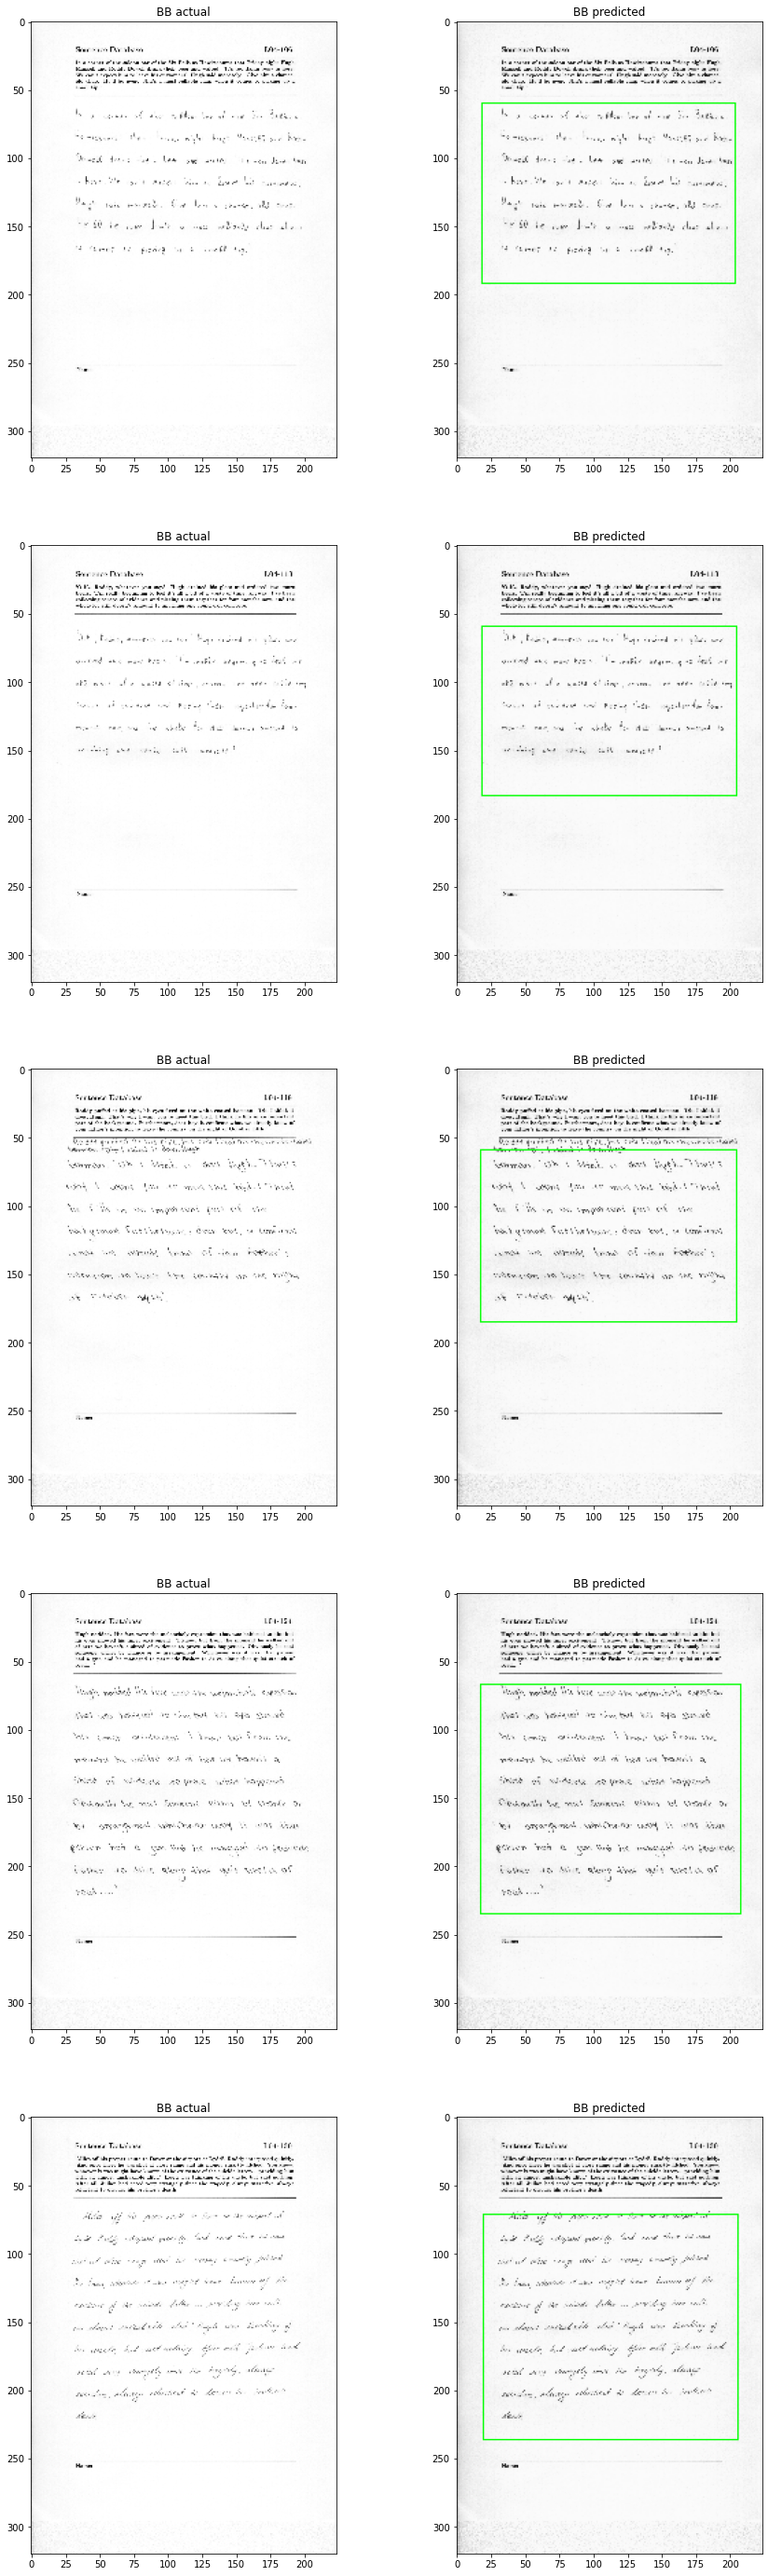

In [0]:
figs_to_plot = 5
fig, axs = plt.subplots(figs_to_plot, 2, figsize=(15, 10 * figs_to_plot))
val_csv = r"/content/drive/My Drive/Handwriting Detection/img_bb_val.csv"
img_folder = r"/content/drive/My Drive/Handwriting Detection/iAmdataset_forms/"
f = open(val_csv, 'r')

for i in range(figs_to_plot):
    line = f.readline()
    filename, x, y, w, h = line.strip().split(',')
    imgfile = img_folder + filename[:-4] + '.png'
    img = preprocess_img(imgfile)
    bb = [x, y, w, h]
    bb_compact = [float(i) for i in bb]
    bb = transform_bb(bb_compact, 0.05)
    #img, bb = augment_transform(img, bb)
    img = np.expand_dims(img, axis=2)
    bb_predicted = model.predict(np.array([img]))

    axs[i][0].imshow(img.squeeze(), cmap='Greys_r')
    axs[i][0].set_title("BB actual")

    color_image = cv2.imread(imgfile)
    color_image = resize_short(color_image, int(224))
    bb_image = draw_bb_onimg(color_image, bb_predicted[0], (0,255,0))

    axs[i][1].imshow(bb_image.squeeze(), cmap='Greys_r')
    axs[i][1].set_title("BB predicted")
